In [1]:
import tensorflow as tf
import os
import time
import scipy
import numpy as np
import shutil
from tqdm import tqdm
from main import layers,load_vgg,optimize

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0
Tests Passed
Tests Passed
Tests Passed


In [2]:
image_shape = (160, 576)

def predict_using_raw_model(l_image_file, model_file="./models_l2_norm_lr_1.00e-04_l2_1.00e-03_e10_batch_1/eproch_9_loss"):
    vgg_path = "./data/vgg/"
    num_classes = 2
    epochs = 50
    batch_size = 16
    tf.reset_default_graph()
    with tf.Session() as sess:
        correct_label = tf.placeholder(tf.int32, [None, None, None, num_classes])
        learning_rate = tf.placeholder(tf.float32)
    
        input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = \
            load_vgg(sess, vgg_path)

        nn_last_layer = layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes)

        logits, training_op, cross_entropy_loss = \
            optimize(nn_last_layer, correct_label, learning_rate, num_classes)
        
        saver = tf.train.Saver()
        saver.restore(sess, model_file)
        l_street_im = []
        for image_file in tqdm(l_image_file):
            image_raw = scipy.misc.imread(image_file)
            image_raw_shape = image_raw.shape[0:2]
            image = scipy.misc.imresize(image_raw, image_shape)
            im_softmax = sess.run(
                [tf.nn.softmax(logits)],
                {keep_prob: 1.0, input_image: [image]})
    
            im_softmax = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
            segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
            mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
            mask = scipy.misc.imresize(mask, image_raw_shape)
            mask = scipy.misc.toimage(mask, mode="RGBA")
            street_im = scipy.misc.toimage(image_raw)
            #street_im = scipy.misc.toimage(image)
            street_im.paste(mask, box=None, mask=mask)
            l_street_im.append(street_im)
    
    return l_street_im

INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'
INFO:tensorflow:Restoring parameters from ./models_l2_norm_lr_1.00e-04_l2_1.00e-03_e10_batch_1/eproch_9_loss


100%|██████████| 290/290 [00:37<00:00,  7.64it/s]


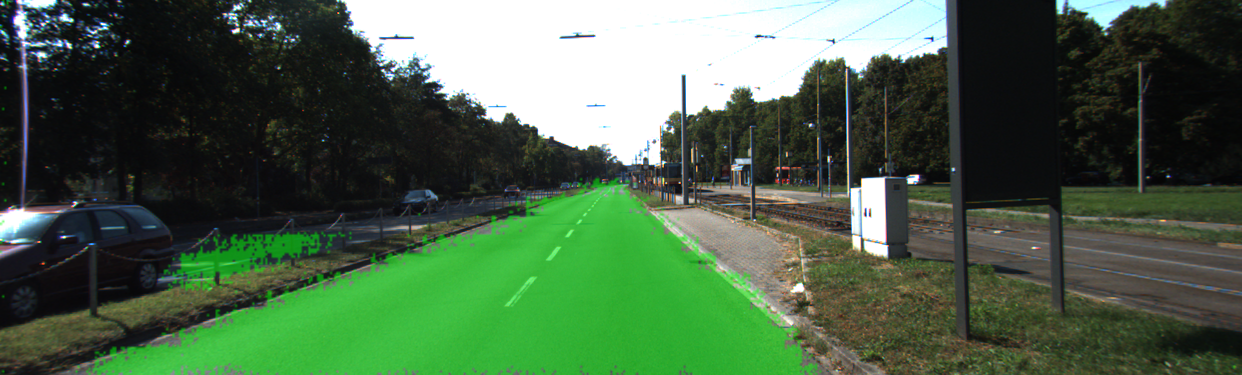

In [3]:
l_input_images = !ls ./data/data_road/testing/image_2/*.png
l_img = predict_using_raw_model(l_input_images)
l_img[0]

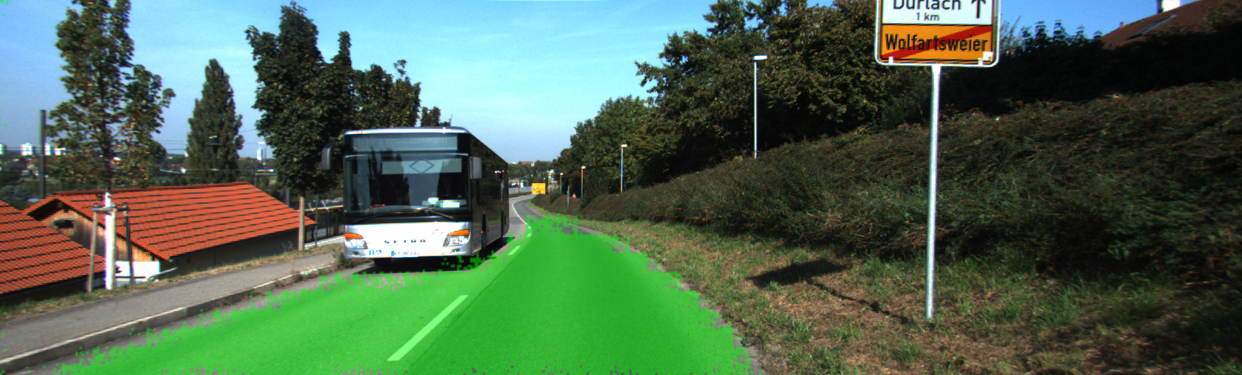

In [4]:
l_img[32]

In [10]:
def load_graph(graph_file, use_xla=False):
    jit_level = 0
    config = tf.ConfigProto()
    if use_xla:
        jit_level = tf.OptimizerOptions.ON_2
        config.graph_options.optimizer_options.global_jit_level = jit_level

    with tf.Session(graph=tf.Graph(), config=config) as sess:
        gd = tf.GraphDef()
        with tf.gfile.Open(graph_file, 'rb') as f:
            data = f.read()
            gd.ParseFromString(data)

        tf.import_graph_def(gd, name='')
        ops = sess.graph.get_operations()
        n_ops = len(ops)
        return sess, ops
    
def predict_using_graphdef_file(l_image_file, graph_file, use_xla=False):
    sess, _ = load_graph(graph_file, use_xla)
    graph = sess.graph
    image_input = graph.get_tensor_by_name("image_input:0")
    keep_prob   = graph.get_tensor_by_name("keep_prob:0")
    logit       = graph.get_tensor_by_name("predicted_label:0")
    l_street_im = []
    for image_file in tqdm(l_image_file):
        image = scipy.misc.imresize(scipy.misc.imread(image_file), image_shape)
        im_softmax = sess.run(
            [logit],
            {keep_prob: 1.0, image_input: np.expand_dims(image, axis=0)})
        
        im_softmax = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
        segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
        mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
        mask = scipy.misc.toimage(mask, mode="RGBA")
        street_im = scipy.misc.toimage(image)
        street_im.paste(mask, box=None, mask=mask)
        l_street_im.append(street_im)
    
    return l_street_im
    

## Using some optimization

The optimized model ran faster, but the result seemed not so well as the origin model.

In [20]:
l_img = predict_using_graphdef_file(l_input_images, graph_file="./freezed_model/frozen_graph.pb")
l_img[0]

  0%|          | 0/290 [00:00<?, ?it/s]


FailedPreconditionError: Attempting to use uninitialized value conv1_1/filter
	 [[Node: conv1_1/filter/read = Identity[T=DT_FLOAT, _class=["loc:@conv1_1/filter"], _device="/job:localhost/replica:0/task:0/gpu:0"](conv1_1/filter)]]
	 [[Node: predicted_label/_5 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_356_predicted_label", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'conv1_1/filter/read', defined at:
  File "/home/huboqiang/miniconda3/envs/carnd-term3/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/huboqiang/miniconda3/envs/carnd-term3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/huboqiang/miniconda3/envs/carnd-term3/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/huboqiang/miniconda3/envs/carnd-term3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/huboqiang/miniconda3/envs/carnd-term3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/huboqiang/miniconda3/envs/carnd-term3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/huboqiang/miniconda3/envs/carnd-term3/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/huboqiang/miniconda3/envs/carnd-term3/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/huboqiang/miniconda3/envs/carnd-term3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/huboqiang/miniconda3/envs/carnd-term3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/huboqiang/miniconda3/envs/carnd-term3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/huboqiang/miniconda3/envs/carnd-term3/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/huboqiang/miniconda3/envs/carnd-term3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/huboqiang/miniconda3/envs/carnd-term3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/huboqiang/miniconda3/envs/carnd-term3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/huboqiang/miniconda3/envs/carnd-term3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/huboqiang/miniconda3/envs/carnd-term3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/huboqiang/miniconda3/envs/carnd-term3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/huboqiang/miniconda3/envs/carnd-term3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/huboqiang/miniconda3/envs/carnd-term3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-81c301863825>", line 1, in <module>
    l_img = predict_using_graphdef_file(l_input_images, graph_file="./models_l2_norm_lr_1.00e-04_l2_1.00e-03_e10_batch_1/eproch_9_loss")
  File "<ipython-input-10-07e353af1f83>", line 20, in predict_using_graphdef_file
    sess, _ = load_graph(graph_file, use_xla)
  File "<ipython-input-10-07e353af1f83>", line 14, in load_graph
    tf.import_graph_def(gd, name='')
  File "/home/huboqiang/miniconda3/envs/carnd-term3/lib/python3.5/site-packages/tensorflow/python/framework/importer.py", line 311, in import_graph_def
    op_def=op_def)
  File "/home/huboqiang/miniconda3/envs/carnd-term3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/huboqiang/miniconda3/envs/carnd-term3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value conv1_1/filter
	 [[Node: conv1_1/filter/read = Identity[T=DT_FLOAT, _class=["loc:@conv1_1/filter"], _device="/job:localhost/replica:0/task:0/gpu:0"](conv1_1/filter)]]
	 [[Node: predicted_label/_5 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_356_predicted_label", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


100%|██████████| 290/290 [00:26<00:00, 11.01it/s]


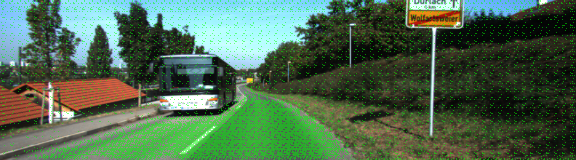

In [7]:
l_img = predict_using_graphdef_file(l_input_images, graph_file="./freezed_model/optimized_graph.pb")
l_img[32]

## One problem

8bit much slower. This has been reported as an issue on tensorflow github [https://github.com/tensorflow/tensorflow/issues/5757](https://github.com/tensorflow/tensorflow/issues/5757). 

In [ ]:
l_img = predict_using_graphdef_file(l_input_images[0:3], graph_file="./freezed_model/eightbit_graph.pb")
l_img[0]

In [ ]:
l_img = predict_using_graphdef_file(l_input_images[0:3], graph_file="./freezed_model/eightbit_graph.pb", use_xla=True)
l_img[0]

# Test on a video

In [15]:
#import imageio
#imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip

In [16]:
class UsingFcnOnVideo(object):
    def __init__(self, graph_file, use_xla=False, image_shape=[160, 576]):
        self.model = graph_file
        self.sess, _ = load_graph(graph_file, use_xla)
        self.image_shape = image_shape
        graph = self.sess.graph
        self.image_input = graph.get_tensor_by_name("image_input:0")
        self.keep_prob   = graph.get_tensor_by_name("keep_prob:0")
        self.logit       = graph.get_tensor_by_name("predicted_label:0")
        
    def process_image(self, image):
        image_raw = image
        image_raw_shape = image_raw.shape[0:2]
            
        image = scipy.misc.imresize(image, self.image_shape)
        im_softmax = self.sess.run(
            [self.logit],
            {self.keep_prob: 1.0, self.image_input: np.expand_dims(image, axis=0)})
        
        im_softmax = im_softmax[0][:, 1].reshape(self.image_shape[0], self.image_shape[1])
        segmentation = (im_softmax > 0.5).reshape(self.image_shape[0], self.image_shape[1], 1)
        mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
        mask = scipy.misc.imresize(mask, image_raw_shape)
        mask = scipy.misc.toimage(mask, mode="RGBA")
        street_im = scipy.misc.toimage(image_raw)
        street_im.paste(mask, box=None, mask=mask)    
        return np.array(street_im, dtype="uint8")
        

In [17]:
m_video = UsingFcnOnVideo("./freezed_model/frozen_graph.pb")

In [18]:
clip = VideoFileClip("../../Project4_AdvancedLaneLines/CarND-Advanced-Lane-Lines/project_video.mp4")
proj_clip = clip.fl_image(m_video.process_image)
%time proj_clip.write_videofile("./project_video.result.mp4", audio=False)

[MoviePy] >>>> Building video ./project_video.result.mp4
[MoviePy] Writing video ./project_video.result.mp4


100%|█████████▉| 1260/1261 [02:14<00:00,  9.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video.result.mp4 

CPU times: user 2min 1s, sys: 15.9 s, total: 2min 17s
Wall time: 2min 15s


In [29]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format("./hardchallenge_video.result.mp4"))

In [28]:
vgg_path = "./data/vgg/"
num_classes = 2
epochs = 50
batch_size = 16
model_file="./models_l2_norm_lr_1.00e-04_l2_1.00e-03_e10_batch_1/eproch_9_loss"
tf.reset_default_graph()
with tf.Session() as sess:
    correct_label = tf.placeholder(tf.int32, [None, None, None, num_classes])
    learning_rate = tf.placeholder(tf.float32)
    
    input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = \
        load_vgg(sess, vgg_path)

    nn_last_layer = layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes)

    logits, training_op, cross_entropy_loss = \
            optimize(nn_last_layer, correct_label, learning_rate, num_classes)
        
    saver = tf.train.Saver()
    saver.restore(sess, model_file)

    def parseImage(image_raw):
        image_raw_shape = image_raw.shape[0:2]
        image = scipy.misc.imresize(image_raw, image_shape)
        im_softmax = sess.run(
            [tf.nn.softmax(logits)],
             {keep_prob: 1.0, input_image: [image]})
    
        im_softmax = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
        segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
        mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
        mask = scipy.misc.imresize(mask, image_raw_shape)
        mask = scipy.misc.toimage(mask, mode="RGBA")
        street_im = scipy.misc.toimage(image_raw)
        street_im.paste(mask, box=None, mask=mask)
        return np.array(street_im)
    

    #image_raw = scipy.misc.imread("./data/data_road/testing/image_2/um_000032.png")
    #outimg = parseImage(image_raw)
    clip = VideoFileClip("../../Project4_AdvancedLaneLines/CarND-Advanced-Lane-Lines/harder_challenge_video.mp4")
    proj_clip = clip.fl_image(parseImage)
    %time proj_clip.write_videofile("./hardchallenge_video.result.mp4", audio=False)
        

INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'
INFO:tensorflow:Restoring parameters from ./models_l2_norm_lr_1.00e-04_l2_1.00e-03_e10_batch_1/eproch_9_loss
[MoviePy] >>>> Building video ./hardchallenge_video.result.mp4
[MoviePy] Writing video ./hardchallenge_video.result.mp4


100%|█████████▉| 1199/1200 [02:54<00:00,  6.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./hardchallenge_video.result.mp4 

CPU times: user 2min 46s, sys: 12.4 s, total: 2min 58s
Wall time: 2min 54s
